In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC
from sklearn.metrics import log_loss, accuracy_score
from sklearn.metrics import f1_score,precision_score, recall_score
from sklearn.metrics import precision_recall_curve, auc
from imblearn.over_sampling import SMOTE
from sklearn.model_selection import GridSearchCV

In [ ]:
with open('predictive_maintainance_1.csv', 'r') as file:
    lines = file.readlines()

# Split lines into columns based on the first 8 spaces or tabs
data = [line.strip().split(None, 9) for line in lines]

# Create a DataFrame from the data
df = pd.DataFrame(data, columns=['UDI', 'Product_ID', 'Type', 'Air_temperature_[K]', 'Process_temperature_[K]', 'Rotational_speed_[rpm]',
                                 'Torque_[Nm]', 'Tool_wear_[min]', 'Target', 'Failure_Type'])

df['Type'] = df['Type'].replace({'L': 0 , 'M': 1 , 'H': 2 })

#remove columns Product_ID, UDI,
df = df.drop(columns=['UDI','Product_ID', 'Failure_Type'])
df = df.drop(columns=['Type'])

# cast values into float
df = df.astype(float)

# Display the DataFrame
print(df.head())
print(df.shape)
df_failure = df[df['Target'] == 1]
df_no_failure = df[df['Target'] == 0]

# Split the DataFrame into features and target variables
# falure dataset
X_failure = df_failure.drop('Target', axis=1)  # Features
y_failure = df_failure['Target']  # Target variable

# no falure dataset
X_no_failure = df_no_failure.drop('Target', axis=1)  # Features
y_no_failure = df_no_failure['Target']  # Target variable

# spliting the datasets into training and validation
# failure data set
X_train_failure, X_test_failure, y_train_failure, y_test_failure = train_test_split(
    X_failure, y_failure, test_size=0.1, random_state=0)

# no_failure dataset
X_train_no_failure, X_test_no_failure, y_train_no_failure, y_test_no_failure = train_test_split(
    X_no_failure, y_no_failure, test_size=0.1, random_state=0)


# merge the taining data set
X_train = pd.concat([X_train_failure, X_train_no_failure], ignore_index =True)
y_train = pd.concat([y_train_failure, y_train_no_failure], ignore_index =True)

# merging the test dataset
X_test = pd.concat([X_test_failure, X_test_no_failure], ignore_index =True)
y_test = pd.concat([y_test_failure, y_test_no_failure], ignore_index =True)

# implementing biased sampling method
smote = SMOTE(random_state=42)
X_resampled, y_resampled = smote.fit_resample(X_train, y_train) # balanced dataset

   Air_temperature_[K]  Process_temperature_[K]  Rotational_speed_[rpm]  \
0                298.1                    308.6                  1551.0   
1                298.2                    308.7                  1408.0   
2                298.1                    308.5                  1498.0   
3                298.2                    308.6                  1433.0   
4                298.2                    308.7                  1408.0   

   Torque_[Nm]  Tool_wear_[min]  Target  
0         42.8              0.0     0.0  
1         46.3              3.0     0.0  
2         49.4              5.0     0.0  
3         39.5              7.0     0.0  
4         40.0              9.0     0.0  
(10000, 6)


In [ ]:
# Using unbalanced training dataset
# Define the parameter grid
param_grid = {
    'C': [0.1, 1, 10],
    'gamma': [0.1, 0.01, 0.001]
}

# Create SVM classifier
svm = SVC()

# Instantiate GridSearchCV
grid_search_unbalanced = GridSearchCV(estimator=svm, param_grid=param_grid, cv=9, scoring='accuracy')

# Unbalanced dataset
# Perform grid search on the training data
grid_search_unbalanced.fit(X_train, y_train)

# Print the best parameters found
print("Best Parameters for unballanced training data:", grid_search_unbalanced.best_params_)



Best Parameters for unballanced training data: {'C': 10, 'gamma': 0.001}


For Unbalanced training dataset:
rbf SVM - Training Accuracy: 0.60
Test Accuracy: 0.971028971028971
rbf SVM - Test Accuracy for failure only dataset: 0.18
rbf SVM - Test Accuracy for no failure only dataset: 1.00
rbf SVM - F1 Score: 0.29268292682926833
Precision: 0.8571428571428571
Recall: 0.17647058823529413
AUC-PR: 0.4934372946930696


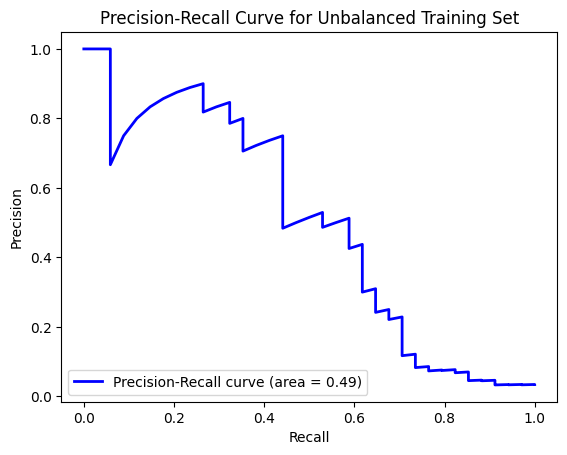

In [ ]:
svm_unbalanced = SVC(C = 1, gamma = 0.001, probability=True)
svm_unbalanced.fit(X_train, y_train)

# Evaluating training accuracy
train_accuracy = accuracy_score(y_resampled, svm_unbalanced.predict(X_resampled))
print("For Unbalanced training dataset:")
print(f"rbf SVM - Training Accuracy: {train_accuracy:.2f}")

# Evaluate the best estimator on the test data
test_accuracy = svm_unbalanced.score(X_test, y_test)
print("Test Accuracy:", test_accuracy)


test_failure_accuracy = accuracy_score(y_test_failure, svm_unbalanced.predict(X_test_failure))
test_no_failure_accuracy = accuracy_score(y_test_no_failure, svm_unbalanced.predict(X_test_no_failure))

print(f"rbf SVM - Test Accuracy for failure only dataset: {test_failure_accuracy:.2f}")
print(f"rbf SVM - Test Accuracy for no failure only dataset: {test_no_failure_accuracy:.2f}")

# F1 score calucation of the model
f1 = f1_score(y_test, svm_unbalanced.predict(X_test))

# Display the F1 score
print("rbf SVM - F1 Score:", f1)
# Compute precision and recall
precision = precision_score(y_test, svm_unbalanced.predict(X_test))
recall = recall_score(y_test, svm_unbalanced.predict(X_test))
print("Precision:", precision)
print("Recall:", recall)

# Predict probabilities of class membership
y_scores = svm_unbalanced.predict_proba(X_test)[:, 1]

# Compute precision-recall curve and area under the curve (AUC)
precision, recall, _ = precision_recall_curve(y_test, y_scores)
auc_pr = auc(recall, precision)

print("AUC-PR:", auc_pr)

# Plot the precision-recall curve
plt.figure()
plt.plot(recall, precision, color='blue', lw=2, label='Precision-Recall curve (area = %0.2f)' % auc_pr)
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve for Unbalanced Training Set')
plt.legend(loc='lower left')
plt.show()

In [ ]:
# For Balanced training dataset
# Define the parameter grid
param_grid = {
    'C': [0.1, 1, 10],
    'gamma': [0.1, 0.01, 0.001]
}

# Create SVM classifier
svm = SVC()

# Instantiate GridSearchCV
grid_search = GridSearchCV(estimator=svm, param_grid=param_grid, cv=9, scoring='accuracy')

# Perform grid search on the training data
grid_search.fit(X_resampled, y_resampled)

# Print the best parameters found
print("Best Parameters for balanced training data:", grid_search.best_params_)



Best Parameters for balanced training data: {'C': 10, 'gamma': 0.01}


For A Balanced training dataset:
rbf SVM - Training Accuracy: 0.99
Test Accuracy: 0.9340659340659341
rbf SVM - Test Accuracy for failure only dataset: 0.41
rbf SVM - Test Accuracy for no failure only dataset: 0.95
rbf SVM - F1 Score: 0.2978723404255319
Precision: 0.23333333333333334
Recall: 0.4117647058823529
AUC-PR: 0.2653550085383877


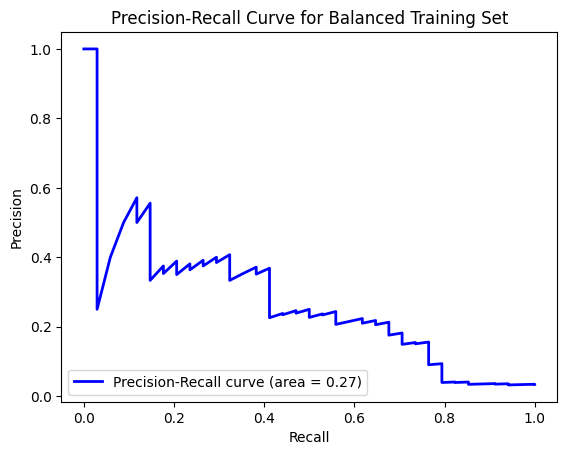

In [7]:
svm_balanced = SVC(C = 10, gamma = 0.01, probability=True)
svm_balanced.fit(X_resampled, y_resampled)

# Evaluating training accuracy
train_accuracy = accuracy_score(y_resampled, svm_balanced.predict(X_resampled))
print("For A Balanced training dataset:")
print(f"rbf SVM - Training Accuracy: {train_accuracy:.2f}")

# Evaluate the best estimator on the test data
test_accuracy = svm_balanced.score(X_test, y_test)
print("Test Accuracy:", test_accuracy)


test_failure_accuracy = accuracy_score(y_test_failure, svm_balanced.predict(X_test_failure))
test_no_failure_accuracy = accuracy_score(y_test_no_failure, svm_balanced.predict(X_test_no_failure))

print(f"rbf SVM - Test Accuracy for failure only dataset: {test_failure_accuracy:.2f}")
print(f"rbf SVM - Test Accuracy for no failure only dataset: {test_no_failure_accuracy:.2f}")

# F1 score calucation of the model
f1 = f1_score(y_test, svm_balanced.predict(X_test))

# Display the F1 score
print("rbf SVM - F1 Score:", f1)
# Compute precision and recall
precision = precision_score(y_test, svm_balanced.predict(X_test))
recall = recall_score(y_test, svm_balanced.predict(X_test))
print("Precision:", precision)
print("Recall:", recall)

# Predict probabilities of class membership
y_scores = svm_balanced.predict_proba(X_test)[:, 1]

# Compute precision-recall curve and area under the curve (AUC)
precision, recall, _ = precision_recall_curve(y_test, y_scores)
auc_pr = auc(recall, precision)

print("AUC-PR:", auc_pr)

# Plot the precision-recall curve
plt.figure()
plt.plot(recall, precision, color='blue', lw=2, label='Precision-Recall curve (area = %0.2f)' % auc_pr)
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve for Balanced Training Set')
plt.legend(loc='lower left')
plt.show()